In [1]:
# PS7
# Collaborators Kimberly and Azul

In [2]:
# Problem 1

In [3]:
# Installing lightcurve
! python -m pip install lightkurve --upgrade

In [4]:
# Imports 
import math
import scipy
import statistics
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.special import gammainc, gamma
from scipy.integrate import quad

In [5]:
# Problem 1
lcs = lk.search_lightcurve("Kepler-7b", mission="Kepler", cadence="short").download_all()
time_all = lcs[0].time.value # get the time of each observation
flux_all = np.array(lcs[0].flux.value.data) # get the flux
flux_err_all = np.array(lcs[0].flux_err.value.data) # get the error in the flux

# Ensures time, flux, and flux_err have same number of elements
assert(len(time_all)==len(flux_all) and len(flux_all)==len(flux_err_all))

In [6]:
# Extracting values in the time between t=261 and t=262 using a mask
mask = (time_all>=261) & (time_all<=262)
time_all = time_all[mask]
flux_all = flux_all[mask]
flux_err_all = flux_err_all[mask]

# Calculate average flux and standard deviation
average_flux_all = np.mean(flux_all)
average_flux_all

106457.66

In [7]:
np.std(flux_all)

287.75525

In [8]:
def exclude_transit(time, flux, flux_err, iterations=5):
    for _ in range(iterations):
        average_flux = np.mean(flux)
        sigma_flux = np.std(flux)

        # Creating a mask to exclude points more than 2σ away from the mean
        transit_mask = np.abs(flux - average_flux) / sigma_flux <= 2
        time = time[transit_mask]
        flux = flux[transit_mask]
        flux_err = flux_err[transit_mask]

    return time, flux, flux_err

time_filtered, flux_filtered, flux_err_filtered = exclude_transit(time_all, flux_all, flux_err_all)

In [9]:
print(time_filtered, flux_filtered, flux_err_filtered)

[261.00017066 261.00085173 261.00153281 ... 261.99729436 261.99865651
 261.99933759] [106560.03 106636.   106611.7  ... 106553.1  106520.72 106534.52] [51.94582  51.97515  52.025043 ... 52.033455 52.03526  52.04274 ]


In [53]:
# normalize flux and flux error
normalized_flux = flux_all / statistics.mean(flux_filtered)
normalized_flux_err = flux_err_all / statistics.mean(flux_err_filtered)

In [11]:
statistics.mean(flux_filtered)

106595.22

<ErrorbarContainer object of 3 artists>

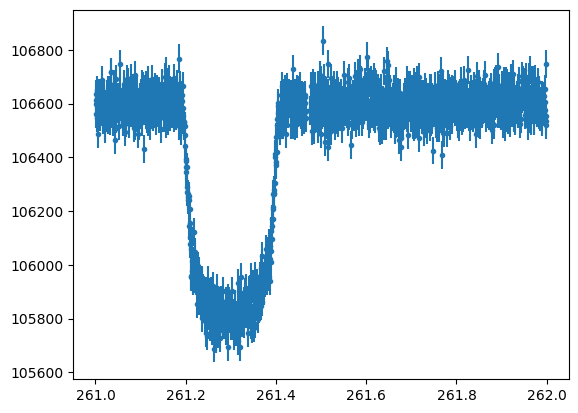

In [12]:
plt.errorbar(time_all, flux_all, yerr=flux_err_all, label='Observed Data', fmt='.')

In [13]:
# Given parameters
p = 0.0775
t0 = 261.3
tau = 0.1

In [14]:
# F theoretical including limb darkening
def predicted_flux(z, p):
    
    def limb_darkening_relation(r):
        return (1 - r**2)**(1/4)

    def delta_function(r, p, z):
        z = math.fabs(z)
        if r >= (z + p) or r <= (z - p): delta_value = 0  
        elif (r + z) <= p              : delta_value = 1 
        else                           : delta_value = math.acos((z**2 - p**2 + r**2)/(2 * z * r)) / math.pi
        return delta_value
    
    def flux_numerator(r):
        flux_numerator_value = limb_darkening_relation(r) * (1 - delta_function(r, p, z)) * 2 * r
        return flux_numerator_value
    
    def flux_denominator(r):
        flux_denominator_value = limb_darkening_relation(r) * 2 * r
        return flux_denominator_value
    
    lowerLim, upperLim = 0, 1
    integralOne, _ = scipy.integrate.quad(flux_numerator,   lowerLim, upperLim)
    integralTwo, _ = scipy.integrate.quad(flux_denominator, lowerLim, upperLim)
    flux_value = integralOne / integralTwo
    return flux_value

def make_z_array(time, t0, tau):
    z_array = (time - t0) / tau
    return z_array

def make_flux_predictions(z_array, p):
    flux_predictions = []
    for z in z_array:
        flux_prediction = predicted_flux(z, p)
        flux_predictions.append(flux_prediction)
    return np.array(flux_predictions)

In [15]:
z_array = make_z_array(time_all, t0, tau)
flux_predictions = make_flux_predictions(z_array, p)

In [49]:
def chi_squared_sum(normalized_flux, flux_predictions, normalized_flux_err):
    chi_squared_sum = 0
    for i in range(len(normalized_flux)):
    
        chi_squared = ((normalized_flux[i]- flux_predictions[i])/normalized_flux_err[i])**2
        chi_squared_sum += chi_squared
        print(normalized_flux[i], flux_predictions[i], normalized_flux_err[i])
    return chi_squared_sum
    
chi_squared_sum(normalized_flux, flux_predictions, normalized_flux_err)

0.9996699 1.0 0.00048731847
1.0003825 1.0 0.00048759364
1.0001546 1.0 0.0004880617
1.0000248 1.0 0.00048773453
1.0005034 1.0 0.00048793803
0.99954236 1.0 0.00048787915
1.0000832 1.0 0.0004881065
1.000123 1.0 0.0004886415
0.99899393 1.0 0.000488177
1.0001183 1.0 0.000488496
1.0000677 1.0 0.0004886203
0.9999031 1.0 0.0004887262
1.0004082 1.0 0.0004889576
1.0001024 1.0 0.0004890154
1.0003599 1.0 0.0004891783
0.99958116 1.0 0.0004891727
1.0000191 1.0 0.0004893787
1.0003275 1.0 0.00048953405
1.0001396 1.0 0.00048961723
1.000267 1.0 0.0004897332
0.99975103 1.0 0.00048970693
0.9997874 1.0 0.0004898048
1.0008525 1.0 0.00049012195
1.0004246 1.0 0.00049009593
0.9994558 1.0 0.00048998685
0.99972194 1.0 0.0004900989
1.0003213 1.0 0.000490249
1.0002123 1.0 0.00049029296
1.0000916 1.0 0.0004902867
1.0001194 1.0 0.00049027667
0.999165 1.0 0.00049010676
0.9992295 1.0 0.00049011665
1.0000297 1.0 0.00049066613
1.0000342 1.0 0.0004901682
0.999916 1.0 0.0004909565
0.99964994 1.0 0.00049001793
1.0001899 1.

10284.46183644657

In [54]:
# Compute chi squared
chi_squared = np.sum(((normalized_flux - flux_predictions)/normalized_flux_err)**2)
print (chi_squared)

0.0024630440722619856


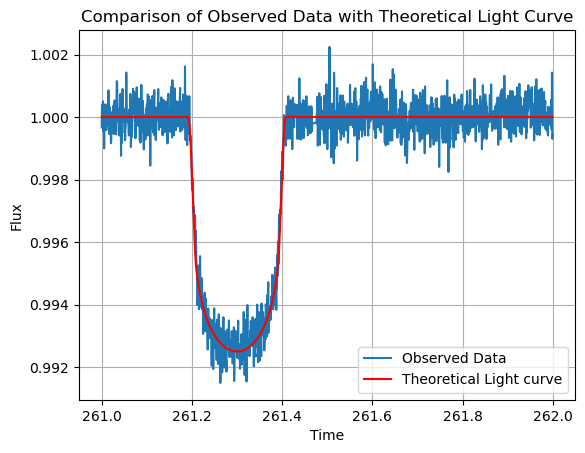

In [18]:
# Problem 2

#Plotting observed vs theoretical data
plt.figure
plt.plot(time_all, normalized_flux, label='Observed Data')
plt.plot(time_all, flux_predictions, label='Theoretical Light curve', color='red')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Comparison of Observed Data with Theoretical Light Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
I would say that this is a very good fit. Nearly perfect.
"""

In [55]:
# Compute liklihood of chi-squared value 
N = len(time_all)
M = 3
nu = N - M

p_value = gammainc(nu / 2, chi_squared / 2)
p_value

0.0

In [ ]:
"""
This is a very low p value and indicates that the model works very well. The probability that the given data was due to random chance is low.
"""

In [20]:
# Problem 3

def make_flux_prediction(time, t0, tau, p):
    z_array = (time - t0) / tau
    flux_predictions = []
    for z in z_array:
        flux_prediction = predicted_flux(z, p)
        flux_predictions.append(flux_prediction)
    return np.array(flux_predictions)

In [56]:
tau_values = np.arange(0.08, 0.13, 0.001)
chi_squared_values = []

for tau in tau_values:
    flux_predictions = make_flux_prediction(time_all, t0, tau, p)
    
    chi_squared = np.sum(((normalized_flux - flux_predictions) / normalized_flux_err) ** 2)
    chi_squared_values.append(chi_squared)
print(chi_squared_values)    
chi_squared_values = np.array(chi_squared_values)

min_chi_squared = np.min(chi_squared_values)
best_tau = tau_values[np.argmin(chi_squared_values)]
print (min_chi_squared, best_tau)

C:\Users\julia\AppData\Local\Temp\ipykernel_1620\3873036732.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integralOne, _ = scipy.integrate.quad(flux_numerator,   lowerLim, upperLim)


[0.001601028652472719, 0.0014998898362069473, 0.0014005772124632068, 0.001302778225036512, 0.0012067418432657583, 0.001112883303934702, 0.001021704138609845, 0.0009337992470362881, 0.0008500569281101805, 0.0007707130982070067, 0.0006964648849079588, 0.0006279542376928144, 0.0005658859532597918, 0.0005107292147305048, 0.00046296919415728544, 0.00042317473668868495, 0.0003916203596490948, 0.0003684942846576009, 0.00035388150398137097, 0.00034781113187966274, 0.00035013207037333104, 0.0003605017394425125, 0.00037847246113446197, 0.0004039291065844349, 0.0004364049826607805, 0.0004755148639906038, 0.0005208590313757129, 0.0005718870702475772, 0.0006283797265464219, 0.0006898637201412497, 0.0007557466816956837, 0.0008254599662351633, 0.0008987154263698529, 0.0009751275929938385, 0.0010543378260672932, 0.0011358633095993006, 0.0012197081840794066, 0.0013058074792983393, 0.0013940001531373967, 0.001484069456189993, 0.0015760503765393477, 0.0016696889142147732, 0.0017648675108725169, 0.0018614

In [57]:
flux_best_fit = make_flux_prediction(time_all, t0, 0.0999999999999999, p)

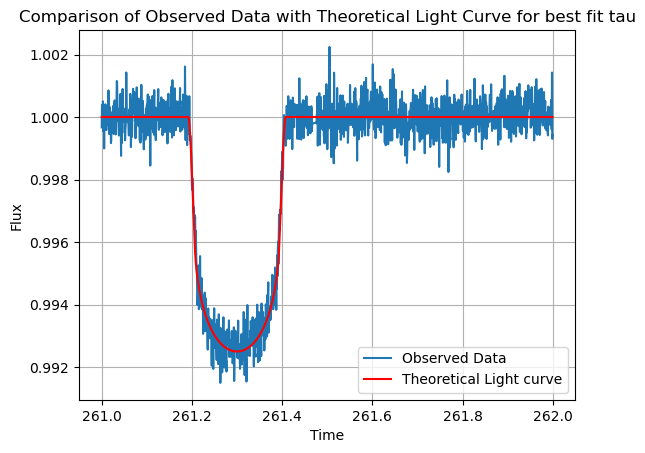

In [58]:
# Plot figure
flux_best_fit = make_flux_prediction(time_all, t0, 0.0999999999999999, p)
plt.figure
plt.plot(time_all, normalized_flux, label='Observed Data')
plt.plot(time_all, flux_best_fit, label='Theoretical Light curve', color='red')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Comparison of Observed Data with Theoretical Light Curve for best fit tau')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
# Calculate p value for best fit tau
p_value_best_fit = gammainc(nu / 2, min_chi_squared / 2)
p_value_best_fit

0.0

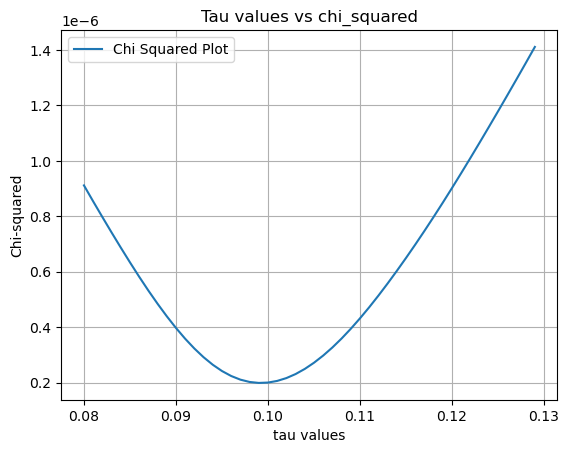

In [25]:
# Plot chi_squared figure
plt.plot(tau_values, chi_squared_values, label="Chi Squared Plot")
plt.xlabel('tau values')
plt.ylabel('Chi-squared')
plt.title('Tau values vs chi_squared')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
sigma_chi_squared = np.std(chi_squared_values)

tau_mask = np.abs(chi_squared_values - min_chi_squared) < sigma_chi_squared

left_mask = tau_values < best_tau
right_mask = tau_values > best_tau

sigma_chi_squared

3.4668061559544747e-07

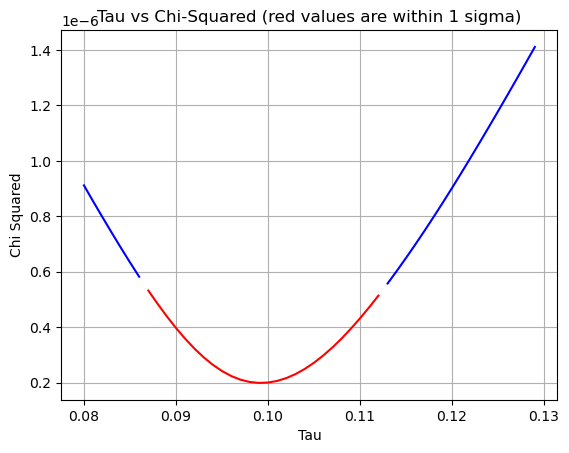

In [28]:
tau_within = tau_values[tau_mask]
chi_squared_within = chi_squared_values[tau_mask]

tau_left = tau_values[(~tau_mask & left_mask)]
chi_squared_left = chi_squared_values[(~tau_mask & left_mask)]

tau_right = tau_values[(~tau_mask & right_mask)]
chi_squared_right = chi_squared_values[(~tau_mask & right_mask)]

plt.plot(tau_left, chi_squared_left, color='blue')
plt.plot(tau_within, chi_squared_within, color='red')
plt.plot(tau_right, chi_squared_right, color='blue')
plt.xlabel('Tau')
plt.ylabel('Chi Squared')
plt.title('Tau vs Chi-Squared (red values are within 1 sigma)')
plt.grid(True)
plt.show()

In [ ]:
"""
The values within one sigma are in red. 
"""